In [1]:
# written on 5.23.24 by @caramnix 

import pandas as pd 
import numpy as np 
import datetime


In [2]:
df= pd.read_csv("/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/CS MS/legislative tweets analysis/tweets_116_merged.csv")

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_10733/2005522887.py:1: DtypeWarning: Columns (1,5,6,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/CS MS/legislative tweets analysis/tweets_116_merged.csv")


In [3]:
df['date'] = pd.to_datetime(df['created_at'])

In [5]:
df['date_grouped']= df.groupby([pd.Grouper(key='date', freq='M')])['date'].transform('mean') # group by month

In [7]:
len(df['date_grouped'].unique()) # woo, 26 groups 

26

In [10]:
# sort, remove Na's 
df = df.sort_values(by='date_grouped')    
df = df[df['date_grouped'].notna()]
df = df[df['party_code'].notna()]

In [12]:
# assign Dem's to 1, Rep's to 0 
df["party_bin"]= np.where(df['party_code']== 100.0, 1, 0) 

In [22]:
def get_month(date): 
    date= str(date)
    y = date.split(" ")[0].split("-")[0]
    m = date.split(" ")[0].split("-")[1]
    d = date.split(" ")[0].split("-")[2]
    
    if y == "2019": 
        return(int(m))
    
    if y == "2020": 
         return(12+ int(m))
        
    if y == "2021": 
         return(24+ int(m))

In [23]:
df['month_num']= df['date_grouped'].apply(get_month)

In [ ]:
# now have month groupings

In [25]:
# text cleaning! 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')

df['text'] = df['text'] = df['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df['text_new'] = df['text'].map(lambda text:re.sub('[^a-zA-Z0-9]+', ' ',text)).apply(lambda x: (x.lower()).split())
df['text_new'] = df['text_new'].apply(lambda words: [word for word in words if word not in eng_stopwords])


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import RandomUnderSampler


In [166]:
# resource on dealing w/ imbalanced data
# question -- if classes imbalanced even if we stratify accuracy, precision, and recall will be poor-- should we instead over or under sample? 
# question -- if I undersample, could changes in accuracy be due to larger samples sizes in future months?

master_data= {} 

scoring = ['accuracy', 'precision', 'f1']
vectorizer = CountVectorizer(min_df= .0001)
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=11)

for month_number in df['month_num'].unique():
    month_i= df[df['month_num']== month_number]

    # make corr corpus
    corpus=[" ".join(i) for i in month_i['text_new']]

    X = vectorizer.fit_transform(corpus)

    X = X.toarray()
    y = month_i['party_bin']

    
    print("preprocessing for " + str(month_number) + " done")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =11, stratify=y)  

    clf = RandomForestClassifier(random_state=11, max_depth= 10)

    print("RF model made")

    scores = cross_validate(clf, X_train, y_train, cv=5,
                    scoring=scoring, return_train_score=False)

    print("cross validation done")

    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state =11)  

    scores2 = cross_validate(clf, X_train2, y_train2, cv=5,
                    scoring=scoring, return_train_score=False)

    print(scores2)

    master_data[month_number] = {'num_tweets': len(month_i), 
                     'scores' : scores, 
                     'month': month_number, 
                     'percent_dem': month_i['party_bin'].sum()/len(month_i), 
                     'scores_undersampled': scores2, 
                     'num_tweets_undersampled': len(X_resampled)
                           }
    
    print("done")
    

preprocessing for 1 done
RF model made
cross validation done
{'fit_time': array([3.84442401, 3.37218404, 3.34464288, 3.33743405, 3.34776783]), 'score_time': array([0.06028509, 0.04556084, 0.04531193, 0.04511285, 0.04557204]), 'test_accuracy': array([0.71270718, 0.73438164, 0.71525712, 0.72928177, 0.72248194]), 'test_precision': array([0.75813008, 0.80458515, 0.77850163, 0.78202479, 0.7665996 ]), 'test_f1': array([0.68819188, 0.70223916, 0.68155894, 0.70385867, 0.70004593])}
done
preprocessing for 2 done
RF model made
cross validation done
{'fit_time': array([4.89072394, 4.24720907, 4.116992  , 4.28838491, 4.168468  ]), 'score_time': array([0.07025218, 0.06123686, 0.06012797, 0.07236695, 0.05691004]), 'test_accuracy': array([0.70052671, 0.71358675, 0.70380128, 0.69890854, 0.68799398]), 'test_precision': array([0.75722543, 0.77277085, 0.74794521, 0.73492908, 0.72148541]), 'test_f1': array([0.66385135, 0.67930889, 0.67546392, 0.67453214, 0.66314506])}
done
preprocessing for 3 done
RF mode

preprocessing for 18 done
RF model made
cross validation done
{'fit_time': array([4.28346014, 4.21986818, 4.09368491, 3.88972402, 3.92048287]), 'score_time': array([0.07051706, 0.06156611, 0.06352425, 0.05485082, 0.05277395]), 'test_accuracy': array([0.71349353, 0.72014787, 0.71856509, 0.71597633, 0.71597633]), 'test_precision': array([0.79450661, 0.80678314, 0.79249012, 0.78044104, 0.793     ]), 'test_f1': array([0.66837826, 0.67468844, 0.6782241 , 0.67946578, 0.67374681])}
done
preprocessing for 19 done
RF model made
cross validation done
{'fit_time': array([5.36891294, 4.50464106, 4.50247884, 4.47687674, 4.52683687]), 'score_time': array([0.08936071, 0.06649327, 0.06785607, 0.06852102, 0.0705893 ]), 'test_accuracy': array([0.70683394, 0.69197755, 0.7041928 , 0.70188181, 0.70452294]), 'test_precision': array([0.79556413, 0.77360308, 0.77931671, 0.76936937, 0.79022989]), 'test_f1': array([0.6501182 , 0.63253249, 0.65325077, 0.6541555 , 0.64833006])}
done
preprocessing for 20 done
RF m

In [245]:
os.getcwd()

'/Users/caranix/Documents/GitHub/CapitolLetters/polarization twitter'

In [248]:
#new_m_d ={} 
#for key in master_data:
#    new_m_d[str(key)] = master_data[key]

In [254]:
new_m_d

{'1': {'num_tweets': 28733,
  'scores': {'fit_time': array([6.73528504, 5.9115541 , 5.85030198, 5.95892286, 5.873384  ]),
   'score_time': array([0.10298586, 0.0902338 , 0.09275317, 0.09021282, 0.08890486]),
   'test_accuracy': array([0.70892369, 0.70867512, 0.70817798, 0.70860269, 0.70785679]),
   'test_precision': array([0.70848892, 0.70831259, 0.7079602 , 0.70831259, 0.70778413]),
   'test_f1': array([0.82937491, 0.82925408, 0.82901253, 0.82925408, 0.8288918 ])},
  'month': 1,
  'percent_dem': 0.7075140082831587,
  'scores_undersampled': {'fit_time': array([3.84442401, 3.37218404, 3.34464288, 3.33743405, 3.34776783]),
   'score_time': array([0.06028509, 0.04556084, 0.04531193, 0.04511285, 0.04557204]),
   'test_accuracy': array([0.71270718, 0.73438164, 0.71525712, 0.72928177, 0.72248194]),
   'test_precision': array([0.75813008, 0.80458515, 0.77850163, 0.78202479, 0.7665996 ]),
   'test_f1': array([0.68819188, 0.70223916, 0.68155894, 0.70385867, 0.70004593])},
  'num_tweets_undersam

In [170]:
#for key in master_data.keys(): 
#    master_data[key]["month"] = key

In [179]:
d = []
for i in range(1, len(master_data) +1 ): 
    score_types= ["test_accuracy", "test_precision", "test_f1"]
    for score_type in score_types: 
        for j in range(0, len(master_data[i]['scores'][score_type])): 
            d.append(
                {
                    'Month' : i, 
                    'Metric': score_type,
                    'Score': master_data[i]['scores'][score_type][j]
                }
            )

d= pd.DataFrame(d)   
    

In [252]:
d.to_csv(os.getcwd() + "/output/scores.csv", index=False)

In [231]:
scores2 = []
for i in range(1, len(master_data) +1 ): 
    score_types= ["test_accuracy", "test_precision", "test_f1"]
    for score_type in score_types: 
        for j in range(0, len(master_data[i]['scores_undersampled'][score_type])): 
            scores2.append(
                {
                    'Month' : i, 
                    'Metric': score_type,
                    'Score': master_data[i]['scores_undersampled'][score_type][j]
                }
            )

scores2= pd.DataFrame(scores2)   
    

In [253]:
scores2.to_csv(os.getcwd() + "/output/scores2.csv", index=False)

<Axes: xlabel='Month', ylabel='Score'>

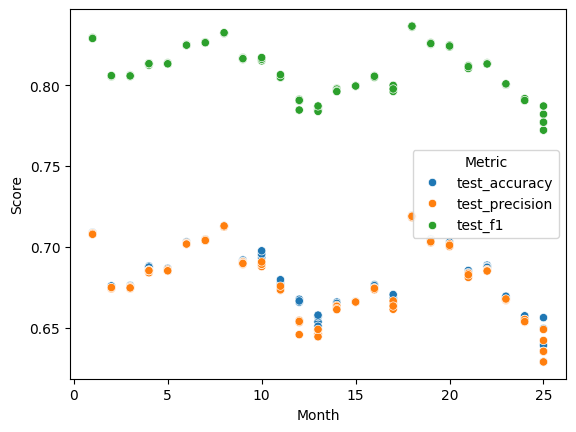

In [181]:
import seaborn as sns

sns.scatterplot(data=d, x="Month", y="Score", hue="Metric")

<Axes: xlabel='Month', ylabel='Score'>

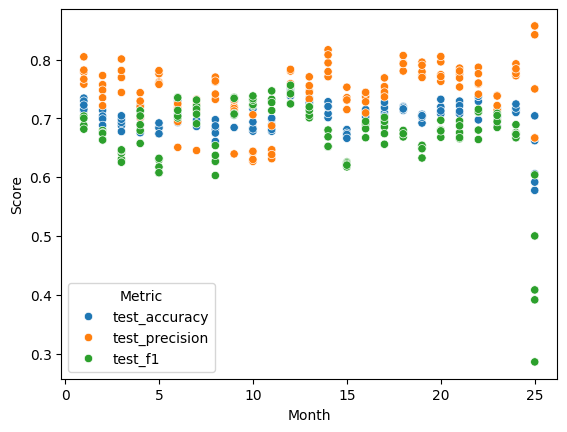

In [185]:
import seaborn as sns

p= sns.scatterplot(data=scores2, x="Month", y="Score", hue="Metric")

In [260]:
scores2= scores2.replace("test_accuracy", "Accuracy")
scores2= scores2.replace("test_precision", "Precision")
scores2= scores2.replace("test_f1", "F1 Score")

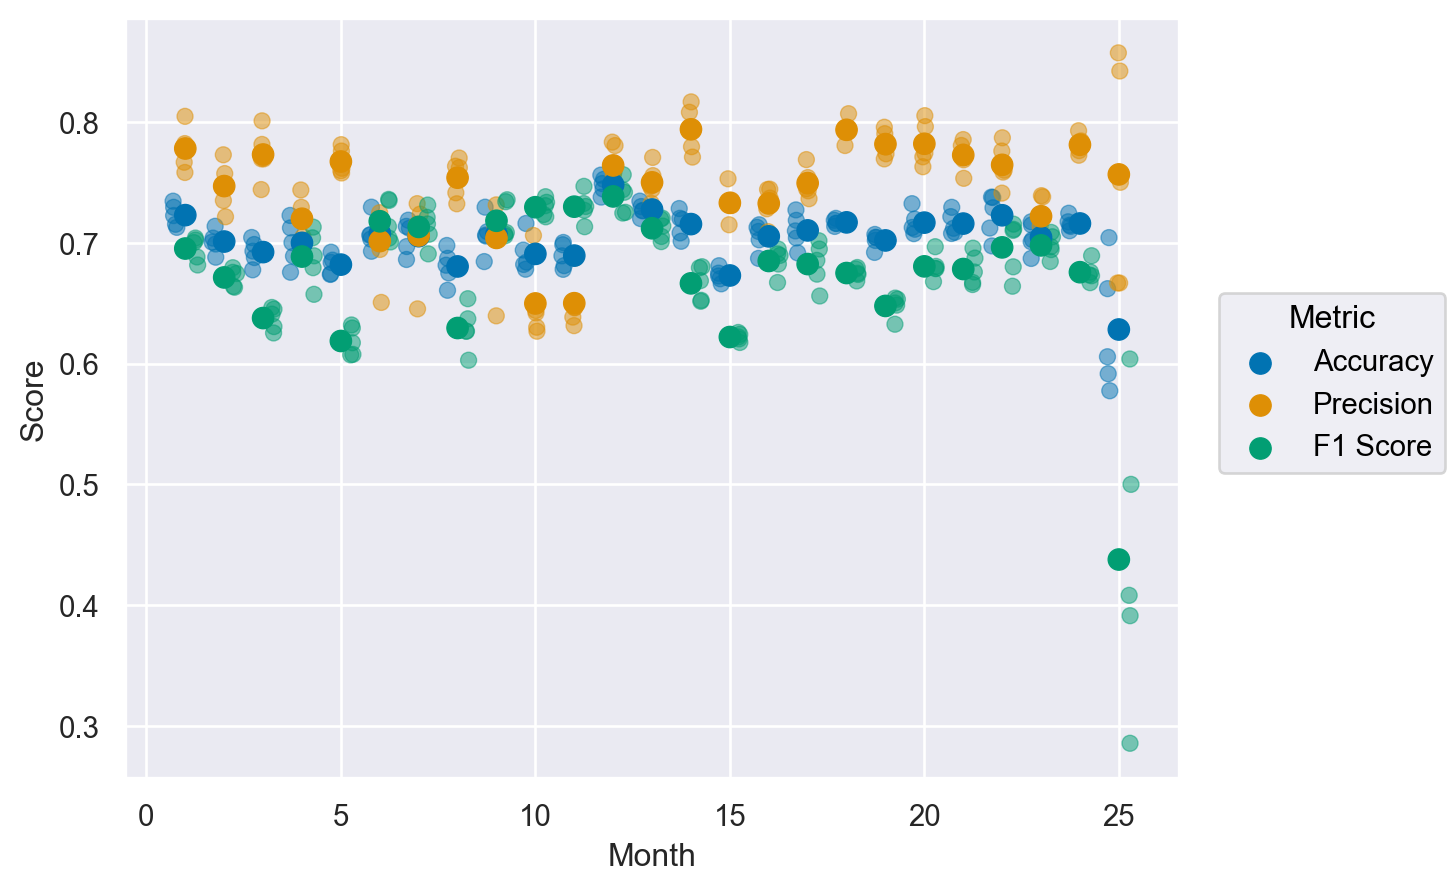

In [261]:
import seaborn.objects as so


so.Plot(scores2, x="Month", y="Score", color="Metric").add(so.Dot(alpha=.5), so.Dodge(), so.Jitter(.4)).add(so.Dot(pointsize=8), so.Agg()).scale(color='colorblind')


In [269]:
from datetime import date

In [287]:
24%12

0

In [289]:
def get_datetime(month_num):
    if month_num> 24: 
        return(date(2021, (month_num % 12) +1, 1))
    elif month_num > 12: 
        return(date(2020, (month_num % 12) +1, 1))
    else: 
        return(date(2019, month_num, 1))
        

In [290]:
scores2["date"]= scores2["Month"].apply(get_datetime)

In [291]:
scores2["date"]

0      2019-01-01
1      2019-01-01
2      2019-01-01
3      2019-01-01
4      2019-01-01
          ...    
370    2021-02-01
371    2021-02-01
372    2021-02-01
373    2021-02-01
374    2021-02-01
Name: date, Length: 375, dtype: object

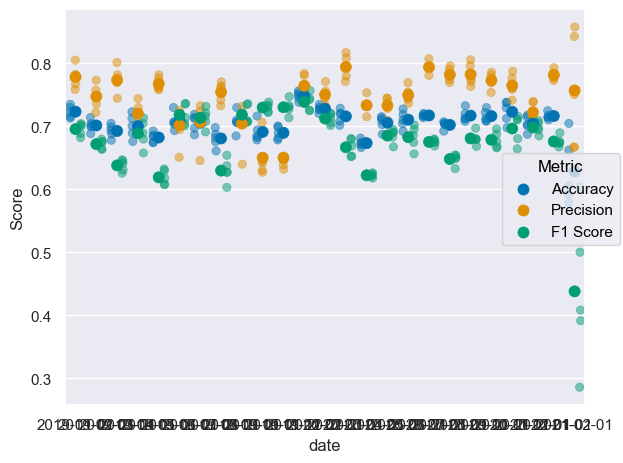

In [292]:
import seaborn.objects as so

plot= (
    so.Plot(scores2, x="date", y="Score", color="Metric")
    .add(so.Dot(alpha=.5), so.Dodge(), so.Jitter(.2))
    .add(so.Dot(pointsize=8), so.Agg())
    .scale(color='colorblind')
)

plot.show()


In [ ]:
sco

In [ ]:
# initial testing 
month_i= df[df['month_num']==1]
# 28733 tweets! 
#make corpus for Jan tweets 
corpus=[" ".join(i) for i in month_i['text_new']]
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df= .0001) # 11702- .0001, .002 - 7292
X = vectorizer.fit_transform(corpus)
X = X.toarray()
y = month_i['party_bin']
# testing 
X_resampled, y_resampled = undersampler.fit_resample(X, y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state =11)  
scores2 = cross_validate(clf, X_train2, y_train2, cv=5,
                    scoring=scoring, return_train_score=False)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =11, stratify=y)    

# Initialize with whatever parameters you want to
forest = RandomForestClassifier(random_state=11).fit(X_train, y_train)
y_prediction = forest.predict(X_test)

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
# Display accuracy score
print(accuracy_score(y_test, y_prediction))

# Display F1 score
print(f1_score(y_test,y_prediction))

from sklearn.metrics import confusion_matrix

# actual on y axis, predicted on x axis 
# actually 0, predicted 1 (actually rep, predicted Dem = 1269)
confusion_matrix(y_test, y_prediction)

clf = RandomForestClassifier(random_state=11, max_depth= 10)

from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision', 'f1']
scores = cross_validate(clf, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=False)

scores